In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
from tqdm.notebook import tqdm
from pathlib import Path
from rdkit import Chem

In [17]:
# Load Actives
actives_path = '/Users/aoxu/projects/PLATE-VS/data/chembl_affinity/uniprot_O14684/O14684_chembl_activities_filtered.parquet'
df_actives = pd.read_parquet(actives_path)

# Load Decoys
decoys_path = '/Users/aoxu/projects/PLATE-VS/data/chembl_affinity/uniprot_O14684/deepcoy_output_test/O14684_generated_decoys.txt'
df_decoys = pd.read_csv(decoys_path, sep=' ', header=None, names=['active_smiles', 'decoy_smiles'])

print(f"Loaded {len(df_actives)} actives and {len(df_decoys)} decoy pairs.")

from rdkit.Chem import Descriptors

def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return pd.Series({
            'MW': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'TPSA': Descriptors.TPSA(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol)
        })
    return pd.Series([None]*6, index=['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds'])

# Calculate properties for Actives (using canonical_smiles from parquet if available, else check columns)
# Let's check columns of df_actives first
print("Actives columns:", df_actives.columns)


Loaded 2018 actives and 100 decoy pairs.
Actives columns: Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value',
       'assay_descripti

Using 'canonical_smiles' as SMILES column for actives.


Calculating Active Properties:   0%|          | 0/1639 [00:00<?, ?it/s]

Calculated properties for 1639 unique actives.


Calculating Decoy Properties:   0%|          | 0/100 [00:00<?, ?it/s]

Calculated properties for 1639 unique actives and 100 unique decoys.


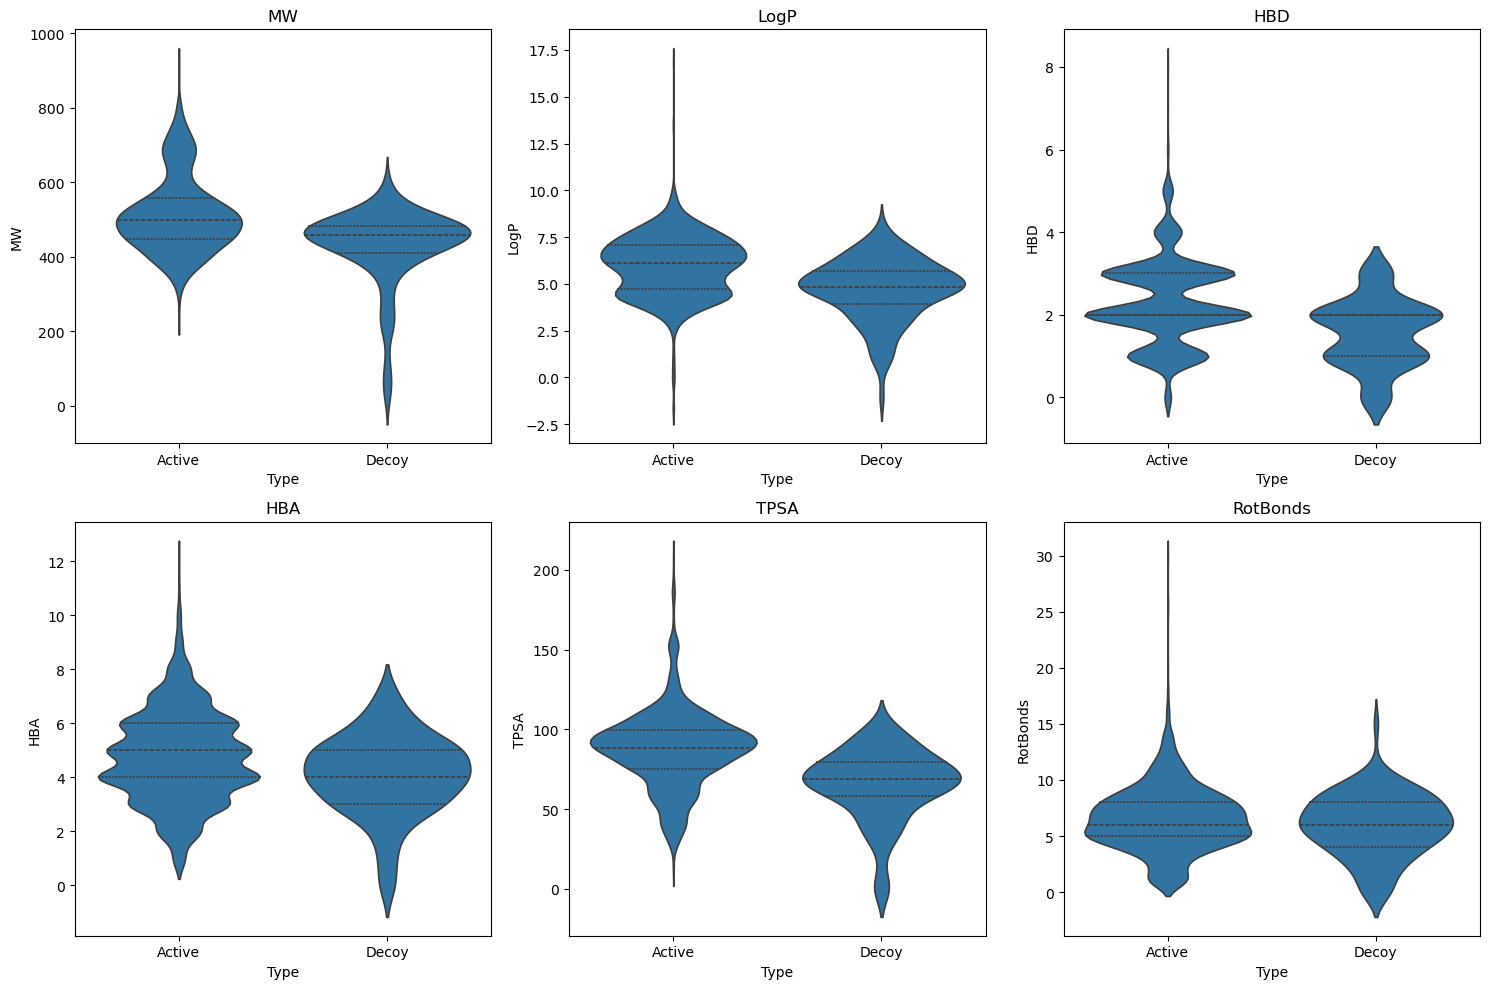

In [18]:
# Identify SMILES column in df_actives
smiles_col = 'canonical_smiles' if 'canonical_smiles' in df_actives.columns else 'smiles'
if smiles_col not in df_actives.columns:
    # Fallback: try to find a column that looks like smiles
    for col in df_actives.columns:
        if 'smiles' in col.lower():
            smiles_col = col
            break

print(f"Using '{smiles_col}' as SMILES column for actives.")

# Calculate properties for unique actives
tqdm.pandas(desc="Calculating Active Properties")
unique_actives = df_actives[smiles_col].drop_duplicates()
df_actives_props = unique_actives.progress_apply(calculate_properties)
df_actives_props['Type'] = 'Active'
print(f"Calculated properties for {len(df_actives_props)} unique actives.")

# Calculate properties for unique decoys
tqdm.pandas(desc="Calculating Decoy Properties")
unique_decoys = df_decoys['decoy_smiles'].drop_duplicates()
df_decoys_props = unique_decoys.progress_apply(calculate_properties)
df_decoys_props['Type'] = 'Decoy'
print(f"Calculated properties for {len(df_actives_props)} unique actives and {len(df_decoys_props)} unique decoys.")

# Combine
df_props = pd.concat([df_actives_props, df_decoys_props], ignore_index=True)

# Plot
properties = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, prop in enumerate(properties):
    sns.violinplot(data=df_props, x='Type', y=prop, ax=axes[i], inner='quartile')
    axes[i].set_title(prop)

plt.tight_layout()
plt.show()

Calculating Shape Similarity:   0%|          | 0/100 [00:00<?, ?it/s]

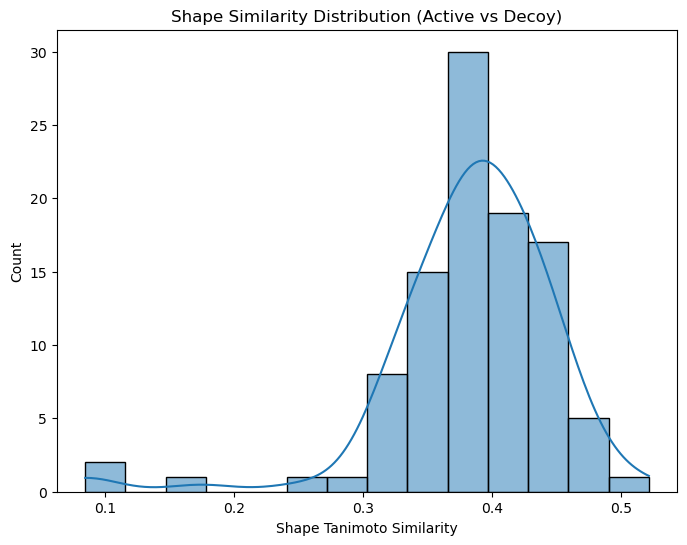

In [19]:
from rdkit.Chem import AllChem, rdShapeAlign, rdShapeHelpers

def calculate_shape_similarity(row):
    smi1, smi2 = row['active_smiles'], row['decoy_smiles']
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    
    if not mol1 or not mol2:
        return None
        
    mol1 = Chem.AddHs(mol1)
    mol2 = Chem.AddHs(mol2)
    
    # Generate conformers
    params = AllChem.ETKDGv3()
    params.useSmallRingTorsions = True
    
    # Embed
    res1 = AllChem.EmbedMolecule(mol1, params)
    res2 = AllChem.EmbedMolecule(mol2, params)
    
    if res1 == -1 or res2 == -1:
        return None
        
    # Align mol2 (probe) to mol1 (ref)
    try:
        # AlignMol modifies mol2 in place to align with mol1s
        rdShapeAlign.AlignMol(mol1, mol2)
        
        # Calculate Tanimoto Shape Distance (0 is identical, 1 is different)
        dist = rdShapeHelpers.ShapeTanimotoDist(mol1, mol2)
        return 1.0 - dist # Similarity
    except Exception as e:
        return None

# Calculate for a subset if too many
tqdm.pandas(desc="Calculating Shape Similarity")
# Taking a sample of 100 for speed in demonstration
df_decoys_sample = df_decoys.sample(min(100, len(df_decoys))).copy()
df_decoys_sample['Shape_Similarity'] = df_decoys_sample.progress_apply(calculate_shape_similarity, axis=1)

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(df_decoys_sample['Shape_Similarity'], kde=True)
plt.title('Shape Similarity Distribution (Active vs Decoy)')
plt.xlabel('Shape Tanimoto Similarity')
plt.show()